In [45]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat

from gibbs.utils import number_of_elements, simple_purify_hamiltonian
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
n=4
k=2
nfields = 5
basisH = KLocalPauliBasis(k,n,False)
c_original = np.zeros(basisH.size); c_original[10:20]=1
control_fields = [np.zeros(basisH.size) for i in range(nfields+1)]
for i,cf in enumerate(control_fields[1:]):
    cf[i*5:(i+1)*5] = -0.25

error = np.zeros(basisH.size); c_original[25:30]=-0.4
cfaulty = c_original + error
states = [simple_purify_hamiltonian(basisH.vector_to_pauli_op(cfaulty + cfield)) for cfield in control_fields]

In [47]:
bl = BayesianLearning(
    states=states,
    control_fields= control_fields,
    constraint_matrix_factory= ConstraintMatrixFactory(n,k,k),
    prior_mean=c_original*0,
    prior_c_cov=np.eye(c_original.shape[0]),
    prior_cfield_cov=np.eye(c_original.shape[0])*1e-5,
    sampling_std= 1e-5,   
)

In [48]:
assert bl.constraint_matrices is None, "The constraint matrices have already been built"
bl.constraint_matrix(0);

In [49]:
# Lx = np.linalg.cholesky(block_diag(bl.current_inv_cov, bl.cfield_inv_cov))
# constraint_matrix = bmat(
#             [
#                 [   bl.constraint_matrix(0),
#                     None
#                 ],
#                 [
#                     bl.constraint_matrix(1),
#                     bl.constraint_matrix(1)
#                 ],
#             ]
#         )

In [50]:
# plt.stairs(c_original)
# # plt.stairs(c_original+control_fields[1])
# plt.stairs(cfaulty)
# print(bl._cost_function(x=np.append(c_original,control_fields[1]),cfield_index = 1,A=constraint_matrix,Lx=Lx))
# print(bl._cost_function(x=np.append(cfaulty,control_fields[1]),cfield_index = 1,A=constraint_matrix,Lx=Lx))

In [51]:
# from scipy.optimize import minimize
# def func(x):
#     cost =  bl._cost_function(x=x,cfield_index = 1,A=constraint_matrix,Lx=Lx)
#     # print(cost)
#     return cost
# # result = minimize(func,np.append(bl.current_mean,control_fields[1]),options={"maxiter":1e5,"xrtol":1e-5})

In [52]:
# plt.stairs(c_original,label = "prior")
# plt.stairs(result.x[:c_original.size],label = "guess")
# plt.stairs(cfaulty,label = "preparation")
# plt.legend()

In [53]:
for i in range(1,nfields):
    update = bl.update_mean(i)
    cov = bl.update_cov(update,i)
    bl.current_mean = update[:update.size//2]
    bl.total_cov = cov

The time it takes for minimize is: 38.88454580307007 for the rest: 0.07350730895996094
The time it takes for minimize is: 254.72004222869873 for the rest: 0.048933982849121094
The time it takes for minimize is: 45.35547494888306 for the rest: 0.08216190338134766
The time it takes for minimize is: 45.49836802482605 for the rest: 0.0585479736328125


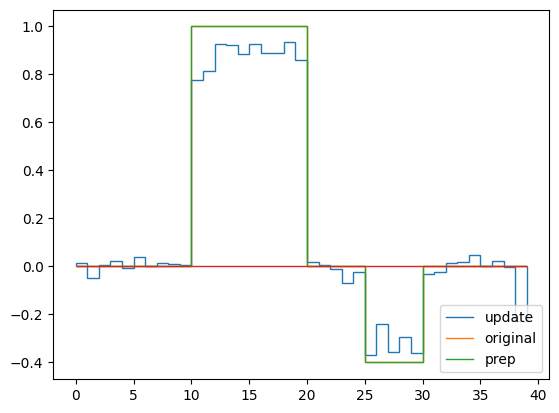

In [54]:
plt.stairs(update[:update.size//2],label="update")
plt.stairs(c_original,label="original")
plt.stairs(cfaulty,label="prep")
# plt.stairs(cfaulty+control_fields[2],label="control prep")
plt.stairs(cov.diagonal()[:cov.diagonal().size//2])
plt.legend(loc="lower right")

In [55]:
update[:update.size//2]-c_original

array([ 0.01463502-1.54737334e-14j, -0.04699775-9.93302662e-15j,
        0.00589566-5.41233725e-15j,  0.02270861+2.06897869e-15j,
       -0.00708753+2.04003481e-15j,  0.04084529-7.23726634e-15j,
        0.00281296-7.75830370e-15j,  0.01298739-1.21314960e-14j,
        0.01192938+1.17859063e-14j,  0.00685603-5.95314408e-15j,
       -0.22478027+2.89524758e-15j, -0.18631402-2.16901368e-15j,
       -0.07382188+2.48412402e-15j, -0.07878192-1.11022302e-15j,
       -0.11551533+6.10622664e-15j, -0.07274094+1.63757896e-15j,
       -0.10919537+4.99600361e-15j, -0.10860528+3.60822483e-16j,
       -0.06675362+7.09848846e-15j, -0.13928339-6.83481050e-16j,
        0.01833883-7.63278329e-15j,  0.00799491-2.52575738e-15j,
       -0.00880837-1.58206781e-15j, -0.07085741+1.66533454e-15j,
       -0.02374072+2.15105711e-16j,  0.02915819-7.70217223e-16j,
        0.15866363-4.10782519e-15j,  0.04417887-5.12784259e-15j,
        0.1056157 -1.63064007e-15j,  0.0381804 -2.34174430e-14j,
       -0.03300807+1.1692